<a href="https://colab.research.google.com/github/evbevz/epoxy-supervisor/blob/main/EpoxyLevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install ultralytics
!git clone https://github.com/evbevz/epoxy-supervisor.git

Lvl:  20 	XY next:  tensor([1026.8000,  159.8000]) 	vNext:  tensor([ -6.2000, -54.8000]) 	L2:  tensor(55.1496) 	Cos2Next:  tensor(0.5621)
Lvl:  19 	XY el_c:  tensor([1033.0000,  214.6000]) 	vSrc:  tensor([ 17.0000, -14.6000]) 	L2:  tensor(22.4089)
Lvl:  18 	XY prev:  tensor([1039.8000,  266.8000]) 	vPrev:  tensor([ 6.8000, 52.2000]) 	L2:  tensor(52.6410) 	Cos2Prev:  tensor(-0.5481)
Длина проекции в пикселях:  tensor(12.5963) 	Длина проекции в мл:  0.22840237617492676


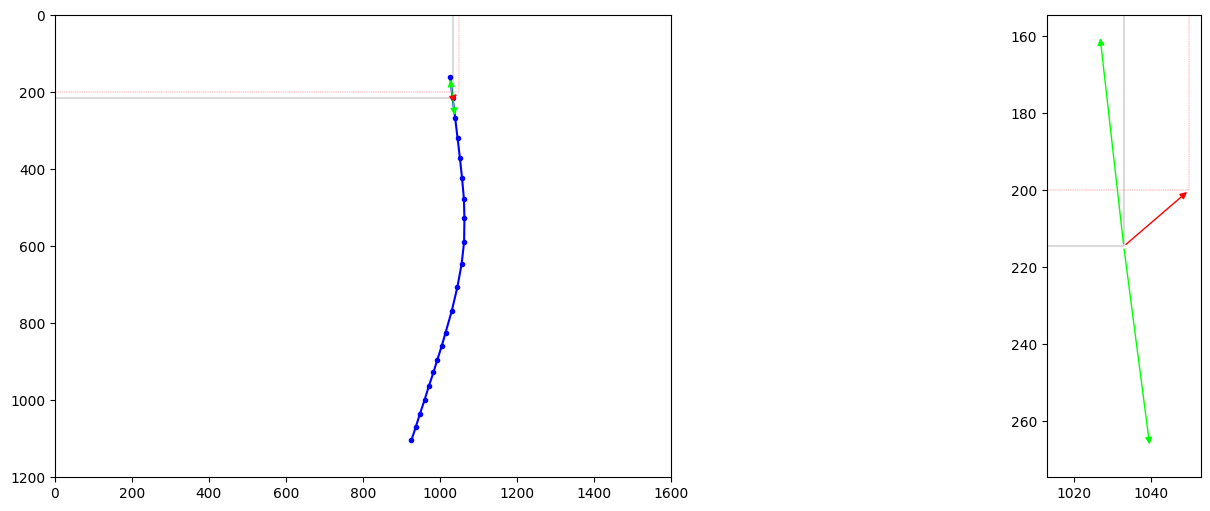

19.228402376174927

In [13]:
from lxml import etree
import matplotlib.pyplot as plt
import os.path
import torch
from ultralytics import YOLO

# Косинусное сходство (Косинус угла между векторами)
def cos_sim (v1, v2):
    cosine_similarity = torch.dot(v1, v2) / (torch.linalg.vector_norm(v1) * torch.linalg.vector_norm(v2))
    return cosine_similarity

# Проекция вектора на вектор
def pr_vec (v1, v2):
    pr_v1_on_v2 = torch.dot(v1, v2) / torch.linalg.vector_norm(v2)
    return pr_v1_on_v2

# Загрузка файла анотации в формате "CVAT for images 1.1"
# Из файла берётся массив точек полилинии с разметкой шкалы деления: 0мл, 1мл, ... 20мл
def Calibrate (fAnnotation):
    tree = etree.parse(fAnnotation)
    root = tree.getroot()
    result = root.xpath('//polyline[@label="injector meter"]')
    if not(result):
        raise Exception("Не удалось найти polyline с точками уровней инжектора в файле: ", fAnnotation)
    points = result[0].attrib['points']
    # Сложная конструкция, но по сути разбирает стороку на список списков (двумерный список) из двух значений попутно переводя из строковых значений в числовое значние.
    list_of_points = list(map(lambda x: list(map(float,x.split(','))), points.split(';')))
    array_of_points = torch.tensor(list_of_points)
    #print ("Массив точек шкалы инжектора:\n", array_of_points)
    return array_of_points

# Получение центра эллипса по точкам: левой и правой большой оси, дальней и ближней малой оси.
# Вычисляем через середину диагоналей эллипса. На будущее стоит просто определять bounding box этого эллипса. Модель будет выдавать уже как раз середину.
def GetEllipseCenter (kpt):
    #print ("Левая точка большой оси:\t", kpt[0])
    #print ("Правая точка большой оси:\t", kpt[1])
    #print ("Дальняя точка малой оси:\t", kpt[2])
    #print ("Ближняя точка малой оси:\t", kpt[3])

    # Проверяем уверенность в определении точки. Если показатель меньше заданного значения, то точку игнорируем.
    # Середина между левой и правой точками большой диагонали эллипса
    if (kpt[0][2] > kptConfidence) and (kpt[1][2] > kptConfidence):
        big_axis_center = (kpt[0][0:2:] + kpt[1][0:2:]) / 2
    else:
        big_axis_center = None
    # Середина между дальней и ближней точками малой диагонали эллипса
    if (kpt[2][2] > kptConfidence) and (kpt[3][2] > kptConfidence):
        small_axis_center = (kpt[2][0:2:] + kpt[3][0:2:]) / 2
    else:
        small_axis_center = None
    # Середина между серединой большой и серединой малой диагоналей. Иногда может быть не равная серединам каждой из них (при ошибках в определении ключевых точек моделью).
    if (big_axis_center is not None) and (small_axis_center is not None):
        ellipse_center = (big_axis_center + small_axis_center) / 2
    elif (big_axis_center is not None) and (small_axis_center is None):
        ellipse_center = big_axis_center
    elif (big_axis_center is None) and (small_axis_center is not None):
        ellipse_center = small_axis_center
    else:
        ellipse_center = None
    #print ("BAC: ", big_axis_center, "SAC: ", small_axis_center, "ELC:", ellipse_center)
    return ellipse_center

# Рисуем район дорасчетных векторов
# Только для дебага
def PlotVectorDedug (ellipse_center, LevelMin):
    arrowprops = {'arrowstyle': '<|-'}
    fig, ax = plt.subplots (1,2,figsize=(18,6))
    ax[0].set_xlim([0,1600])
    ax[0].set_ylim([0,1200])
    ax[0].set_aspect(1)
    ax[0].invert_yaxis()
    ax[0].plot (arrayEpoxyLevel[::,0],arrayEpoxyLevel[::,1],'b.-')
    ax[0].annotate('',xy=arrayEpoxyLevel[LevelMin],xytext=ellipse_center,arrowprops=arrowprops|{'color': '#ff0000'})
    ax[0].annotate('',xy=arrayEpoxyLevel[LevelMin],xytext=arrayEpoxyLevel[LevelMin-1],arrowprops=arrowprops|{'color': '#00ff00'})
    ax[0].annotate('',xy=arrayEpoxyLevel[LevelMin],xytext=arrayEpoxyLevel[LevelMin+1],arrowprops=arrowprops|{'color': '#00ff00'})
    ax[0].hlines(y=arrayEpoxyLevel[LevelMin][1:2:], xmin=0, xmax=arrayEpoxyLevel[LevelMin][0:1:], color='black', alpha=0.7, linewidth=0.3, linestyles='solid')
    ax[0].vlines(x=arrayEpoxyLevel[LevelMin][0:1:], ymin=0, ymax=arrayEpoxyLevel[LevelMin][1:2:], color='black', alpha=0.7, linewidth=0.3, linestyles='solid')
    ax[0].hlines(y=ellipse_center[1:2:], xmin=0, xmax=ellipse_center[0:1:], color='red', alpha=0.7, linewidth=0.3, linestyles='dashed')
    ax[0].vlines(x=ellipse_center[0:1:], ymin=0, ymax=ellipse_center[1:2:], color='red', alpha=0.7, linewidth=0.3, linestyles='dashed')
    ax[1].set_xlim(arrayEpoxyLevel[LevelMin][0:1:]-20, arrayEpoxyLevel[LevelMin][0:1:]+20)
    ax[1].set_ylim(arrayEpoxyLevel[LevelMin][1:2:]-60, arrayEpoxyLevel[LevelMin][1:2:]+60)
    ax[1].set_aspect(1)
    ax[1].invert_yaxis()
    ax[1].annotate('',xy=arrayEpoxyLevel[LevelMin],xytext=ellipse_center,arrowprops=arrowprops|{'color': '#ff0000'})
    ax[1].annotate('',xy=arrayEpoxyLevel[LevelMin],xytext=arrayEpoxyLevel[LevelMin-1],arrowprops=arrowprops|{'color': '#00ff00'})
    ax[1].annotate('',xy=arrayEpoxyLevel[LevelMin],xytext=arrayEpoxyLevel[LevelMin+1],arrowprops=arrowprops|{'color': '#00ff00'})
    ax[1].hlines(y=arrayEpoxyLevel[LevelMin][1:2:], xmin=0, xmax=arrayEpoxyLevel[LevelMin][0:1:], color='black', alpha=0.7, linewidth=0.3, linestyles='solid')
    ax[1].vlines(x=arrayEpoxyLevel[LevelMin][0:1:], ymin=0, ymax=arrayEpoxyLevel[LevelMin][1:2:], color='black', alpha=0.7, linewidth=0.3, linestyles='solid')
    ax[1].hlines(y=ellipse_center[1:2:], xmin=0, xmax=ellipse_center[0:1:], color='red', alpha=0.7, linewidth=0.3, linestyles='dashed')
    ax[1].vlines(x=ellipse_center[0:1:], ymin=0, ymax=ellipse_center[1:2:], color='red', alpha=0.7, linewidth=0.3, linestyles='dashed')
    plt.show()

def GetEpoxyLevel (model, arrayEpoxyLevel, file):
    # Запускаем предсказание
    results = model.predict(source=filenameInjectorCam, verbose=False)  # Предсказание по изображению. Возвращается список результатов (т.к. можно передать список кадров или даже видео)
    # Теоретически может быть список результатов, но берём только одно - первое.
    keypoints = results[0].keypoints  # Keypoints object for pose outputs
    #results[0].show()  # display to screen
    #print ('--- Keypoints: ---\n', keypoints)

    # Высчитываем центр эллипса
    # Передаем в параметре 4 точки диагоналей эллипса в виде тензора 4x3 [[x1,y2,confidence1],[]...]
    ellipse_center = GetEllipseCenter(keypoints.data[0][2:6:])
    #ellipse_center = GetEllipseCenter(torch.tensor([[8.2964e+02, 1.1205e+03, 9.8753e-01],
    #    [1.0747e+03, 1.1256e+03, 9.1424e-01],
    #    [9.5690e+02, 1.0506e+03, 9.9983e-01],
    #    [0.0000e+00, 0.0000e+00, 3.4417e-01]], device='cuda:0'))

    # Для отладки
    ellipse_center=torch.tensor([1050, 200])

    if ellipse_center is not None:
        # Переносим массив точек шприца на то же устройство рассчета где и тензоры модели предсказаний. Если расчёты велись на CUDA, то лучше там и считать всё остальное.
        arrayEpoxyLevel = arrayEpoxyLevel.to(ellipse_center.device)

        # Вычисляем ближайшую калиброванную точку к предсказанной точке (середине эллипса)
        LengthMin = (keypoints.orig_shape[0] ** 2 + keypoints.orig_shape[1] ** 2) ** 0.5 # Нужно просто большое значение, но решил указать максимально возможное расстояние на изображении (диагональ)
        LevelMin = 0
        for level, kpt in enumerate(arrayEpoxyLevel):
            Length = torch.norm(ellipse_center - kpt) # Расстояние между предсказанной точкой и калиброванной точкой уровня
            if Length < LengthMin:                    # Если решим, что хоти чтобы при одинаковом расстоянии показывал значение большего уровня, то тогда поставить знак сравнения <=
                LengthMin = Length                    # Запоминаем минимальное расстояние
                LevelMin = level                      # Запоминаем уровень к точке которого расстояние минимальное
            #print ("Lvl: ", level, "\tCalib pt: ", kpt, "\tPredict pt: ", ellipse_center, "\tLength: ", Length)
        #print ("Предсказанный уровень эпоксидки: ", LevelMin)

        # Дорасчёт дробной части уровня.
        # Определяем с какой стороны от ближайшей калиброванной точки уровня находится точка предсказания и на каком расстоянии
        vSrc = ellipse_center - arrayEpoxyLevel[LevelMin]
        vNext = arrayEpoxyLevel[LevelMin+1] - arrayEpoxyLevel[LevelMin]
        vPrev = arrayEpoxyLevel[LevelMin-1] - arrayEpoxyLevel[LevelMin]
        cos_next = cos_sim(vSrc,vNext)
        cos_prev = cos_sim(vSrc,vPrev)

        print ("Lvl: ", LevelMin+1, "\tXY next: ", arrayEpoxyLevel[LevelMin+1], "\tvNext: ", vNext, "\tL2: ", torch.linalg.vector_norm(vNext), "\tCos2Next: ", cos_next)
        print ("Lvl: ", LevelMin, "\tXY el_c: ", arrayEpoxyLevel[LevelMin], "\tvSrc: ", vSrc, "\tL2: ", torch.linalg.vector_norm(vSrc))
        print ("Lvl: ", LevelMin-1, "\tXY prev: ", arrayEpoxyLevel[LevelMin-1], "\tvPrev: ", vPrev, "\tL2: ", torch.linalg.vector_norm(vPrev), "\tCos2Prev: ", cos_prev)

        # Если точка выше ближайшего калиброванного уровня, то добавляем дорасчитанную дробную часть объема
        if cos_next > cos_prev:
            pr = pr_vec(vSrc, vNext)
            pr_ml = float (1 / torch.linalg.vector_norm(vNext) * pr)
        # Если точка ниже ближайшего калиброванного уровня, то вычитаем дорасчитанную дробную часть объема
        elif cos_next < cos_prev:
            pr = pr_vec(vSrc, vPrev)
            pr_ml = - float (1 / torch.linalg.vector_norm(vPrev) * pr)
        else:
            pr = 0
            pr_ml = 0

        print ("Длина проекции в пикселях: ", pr, "\tДлина проекции в мл: ", pr_ml)
        PlotVectorDedug(ellipse_center, LevelMin)

        return LevelMin + pr_ml
    else:
        return None

# Значение уверенности в правильности распознавания, ниже которого не будем считать, что точки определились правильно. Т.е. координаты такой точки будем считать ложными и точку игнорировать.
kptConfidence = 0.8 # Сейчас точки если и распознаются, то с уверенностью больше 0.9

# Калибровочный файл в котором хранятся уровни от 0 до 20мл. В виде координат X,Y центра эллипса поверхности эпоксидки на каждом уровне.
filenameAnnotation = 'epoxy-supervisor/samples/EpoxyLevelCalibrate.annotations.xml'

# Файл весов обученной для распознавания модели
filenameAIModel = 'epoxy-supervisor/weights/epoxy-supervisor.20241228.best.pt'

# Изображение для предсказания уровня эпоксидки
#filenameInjectorCam = 'epoxy-supervisor/samples/fail01.png'
filenameInjectorCam = 'epoxy-supervisor/samples/000030.png'

# Калибруем шприц
arrayEpoxyLevel = Calibrate(filenameAnnotation)

# Загружаем модель
model = YOLO(filenameAIModel)

# Запрос уровня по изображению
GetEpoxyLevel(model, arrayEpoxyLevel, filenameInjectorCam)